# σ / β Heatmap

In [1]:
using CSV
using DataFrames
using Plots
using Glob
using StatsBase: mean

In [2]:
function csv_to_df(dir_name_vec::Vector{String})::Vector{DataFrame}
    csv_file_names = []

    for dir_name in dir_name_vec
        append!(csv_file_names, glob("../output/$(dir_name)/*.csv"))
        append!(csv_file_names, glob("../output/$(dir_name)/**/*.csv"))
    end
    
    return [CSV.File(csv_file_name) |> DataFrame for csv_file_name in csv_file_names]
end

function get_value(
    df::AbstractDataFrame,
    x::Float64,
    y::Float64,
    x_symbol::Symbol,
    y_symbol::Symbol,
    value_symbol::Symbol,
)::Union{Float64,Missing}
    values = df[df[:, x_symbol] .== x .&& df[:, y_symbol] .== y, value_symbol]
    if length(values) > 0
        mean(values)
    else
        missing
    end
end

function calc_mean(df::DataFrame, key_columns::Vector{String}, value_columns::Vector{String})::DataFrame
    transformations = [col => mean => col for col in value_columns]
    df = combine(groupby(df, key_columns), transformations...)

    return df
end

function make_mean_df(df_vec::Vector{DataFrame}, key_columns::Vector{String}, value_columns::Vector{String})::DataFrame
    mean_df = vcat([calc_mean(df, key_columns, value_columns) for df in df_vec]...)
    mean_df = calc_mean(mean_df, key_columns, value_columns)

    return sort(mean_df, key_columns)
end;

In [3]:
COLOR_MAP = cgrad([
    RGB(0xB3/255, 0x20/255, 0x34/255),  # red   #B32034
    RGB(0xE3/255, 0xE3/255, 0xE3/255),  # white #E3E3E3
    RGB(0x2D/255, 0x57/255, 0x9A/255)   # blue  #2D579A
])

function plot_σβ_heatmap(df::AbstractDataFrame, symbol::Symbol, title::String, xlims, xticks)::Plots.Plot
    β = sort(unique(df.β))
    σ = sort(unique(df.sigma))

    return heatmap(
        σ,
        β,
        reshape([get_value(df, s, b, :sigma, :β, symbol) for b in β, s in σ], length(β), length(σ)),
        xlabel = "σ",
        ylabel = "β",
        xlims = xlims,
        ylims = (-0.05, 0.95),
        xticks = xticks,
        yticks = 0:0.1:0.9,
        clims = (0.05, 0.95),
        title = title,
        color = COLOR_MAP,
    )
end;

In [4]:
df_vec = csv_to_df([
    # "20240125_NC_σβ_Heatmap", # 正規化パターン1 (std_weight_sumがおかしい) (1.7, -0.7)
    # "20240126_NC_σβ_Heatmap", # 正規化パターン2 POPULATION & PAYOFF (1.6, -0.6) 20 trial
    # "20240127_NC_σβ_Heatmap", # 正規化パターン3 (1以上切り捨て) POPULATION & PAYOFF (1.5, -0.5) 20 trial
    # "20240128_NC_σβ_Heatmap", # 正規化パターン4
    "20240129_105841", # 正規化パターン5
    "20240129_105849", # 正規化パターン5 (これでダメなら、ちょっと集計対象の世代を調整してみる)
])
columns = names(df_vec[1])
key_columns = columns[1:15]
value_columns = columns[17:end]
mean_df = make_mean_df(df_vec, key_columns, value_columns)
mean_df = mean_df[mean_df.β .!= 1.0, :]

Row,initial_N,initial_k,initial_T,S,initial_w,Δw,interaction_freqency,reproduction_rate,δ,initial_μ_s,initial_μ_r,β,sigma,generations,variability_mode,N,T,cooperation_rate,payoff_μ
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,String15,Float64,Float64,Float64,Float64
1,1000,100,1.5,-0.5,0.5,0.05,1.0,0.05,1.0,0.01,0.01,0.0,0.0,10000,PAYOFF,1000.0,1.5,0.383219,0.764016
2,1000,100,1.5,-0.5,0.5,0.05,1.0,0.05,1.0,0.01,0.01,0.0,0.0,10000,POPULATION,1000.0,1.5,0.38907,0.775398
3,1000,100,1.5,-0.5,0.5,0.05,1.0,0.05,1.0,0.01,0.01,0.0,0.05,10000,PAYOFF,1000.0,1.50045,0.395691,0.789778
4,1000,100,1.5,-0.5,0.5,0.05,1.0,0.05,1.0,0.01,0.01,0.0,0.1,10000,PAYOFF,1000.0,1.49802,0.414391,0.825833
5,1000,100,1.5,-0.5,0.5,0.05,1.0,0.05,1.0,0.01,0.01,0.0,0.15,10000,PAYOFF,1000.0,1.49927,0.446716,0.88986
6,1000,100,1.5,-0.5,0.5,0.05,1.0,0.05,1.0,0.01,0.01,0.0,0.2,10000,PAYOFF,1000.0,1.49747,0.378089,0.752557
7,1000,100,1.5,-0.5,0.5,0.05,1.0,0.05,1.0,0.01,0.01,0.0,0.25,10000,PAYOFF,1000.0,1.49855,0.491634,0.977591
8,1000,100,1.5,-0.5,0.5,0.05,1.0,0.05,1.0,0.01,0.01,0.0,0.3,10000,PAYOFF,1000.0,1.49589,0.571266,1.13602
9,1000,100,1.5,-0.5,0.5,0.05,1.0,0.05,1.0,0.01,0.01,0.0,0.35,10000,PAYOFF,1000.0,1.50335,0.482691,0.959405


initial_N = 1000, initial_k = 100, initial_T = 1.5, S = -0.5, initial_w = 0.5, Δw = 0.05, interaction_freqency = 1.0, reproduction_rate = 0.05, δ = 1.0, initial_μ_s = 0.01, initial_μ_r = 0.01, generations = 10000, variability_mode = PAYOFF

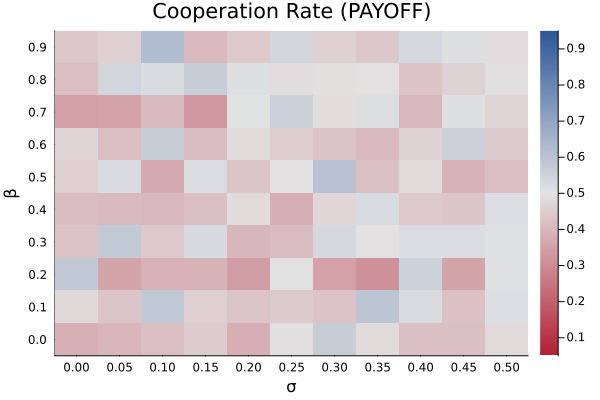

initial_N = 1000, initial_k = 100, initial_T = 1.5, S = -0.5, initial_w = 0.5, Δw = 0.05, interaction_freqency = 1.0, reproduction_rate = 0.05, δ = 1.0, initial_μ_s = 0.01, initial_μ_r = 0.01, generations = 10000, variability_mode = POPULATION

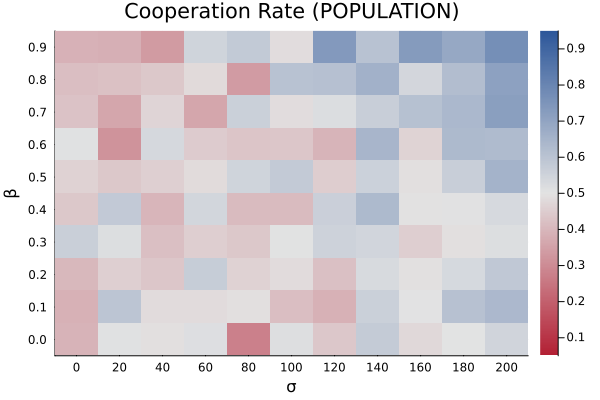

In [5]:
key_index = [1:11; 14:15]

for df in groupby(mean_df, names(mean_df)[key_index])
    title = join(["$(k) = $(v)" for (k, v) in pairs(df[1, key_index])], ", ")
    print(title)
    
    if df.variability_mode[1] == "POPULATION"
        xlims = (-10, 210)
        xticks = 0:20:200
    elseif df.variability_mode[1] == "PAYOFF"
        xlims = (-0.025, 0.525)
        xticks = 0:0.05:0.5
    elseif df.variability_mode[1] ∈ ["STRATEGY_MUTATION", "RELATIONSHIP_MUTATION"]
        xlims = (-0.0025, 0.0525)
        xticks = 0:0.005:0.05
    end
    
    p = plot_σβ_heatmap(df, :cooperation_rate, "Cooperation Rate ($(df.variability_mode[1]))", xlims, xticks)
    display(p)
    savefig(p, "../img/NC/fig_σβ_heatmap_$(df.variability_mode[1]).png")
end